## 1. Setup and Data Preparation

We begin by importing the necessary packages and preparing the Brent oil price data. The log return series is used instead of raw prices, as it tends to be stationary and better captures structural shifts.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("../data/brent_prices_cleaned.csv", parse_dates=["Date"], index_col="Date")
df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna()
returns = df['log_return'].values
n = len(returns)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## 2. Bayesian Change Point Model in PyMC3

We implement a basic Bayesian model with a single change point in the mean. The variance is assumed constant for simplicity. The change point (`tau`) is modeled as a discrete uniform prior, while the means before and after (`mu_1`, `mu_2`) are drawn from normal priors.

In [2]:
with pm.Model() as model:
    # Priors
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    mu_1 = pm.Normal('mu_1', mu=0, sigma=1)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Switch mean based on time index
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    # MCMC Sampling: 100 draws, 250 tuning steps, 2 chains
    trace = pm.sample(
        draws=100,          # ⬅️ number of posterior samples per chain
        tune=250,           # ⬅️ number of tuning (warm-up) steps
        chains=2,           # default
        target_accept=0.95,
        return_inferencedata=True
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 250 tune and 100 draw iterations (500 + 200 draws total) took 25491 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## 3. Posterior Diagnostics

We check convergence using ArviZ summaries and trace plots. The `r_hat` value should be close to 1.0, and the posterior of the change point (`tau`) should be tightly concentrated if a shift exists.

array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'mu_1'}>,
        <Axes: title={'center': 'mu_1'}>],
       [<Axes: title={'center': 'mu_2'}>,
        <Axes: title={'center': 'mu_2'}>]], dtype=object)

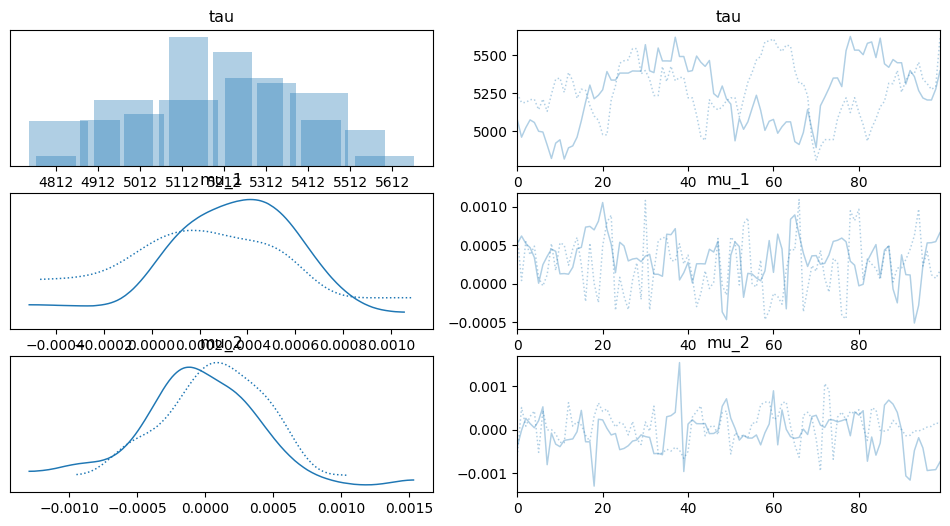

In [3]:
az.summary(trace, var_names=["tau", "mu_1", "mu_2", "sigma"])
az.plot_trace(trace, var_names=["tau", "mu_1", "mu_2"])

## 4. Change Point Estimation

We extract the most probable index of the change point (`tau`) and convert it into a calendar date.

In [4]:
# Most probable change point
tau_samples = trace.posterior['tau'].values.flatten()
tau_mean_idx = int(np.round(np.mean(tau_samples)))
change_date = df.index[tau_mean_idx]

print(f"Estimated change point date: {change_date.date()}")

Estimated change point date: 2008-01-17


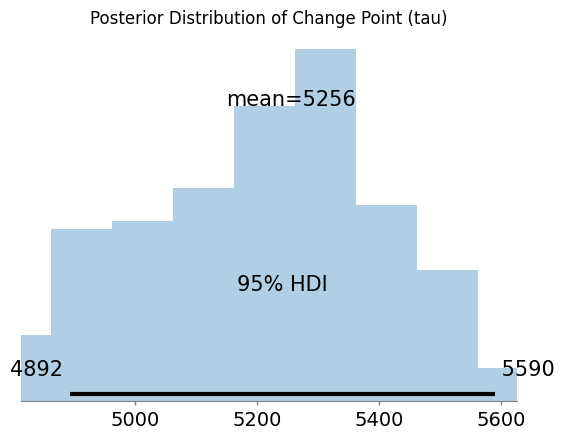

Most probable change point (index): 5255
Estimated change point date: 2008-01-16


In [13]:
# 🔍 Step 1: Extract and Visualize Change Point
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Plot posterior distribution of tau (change point)
az.plot_posterior(trace, var_names=["tau"], hdi_prob=0.95)
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()

# Most likely change point index
tau_most_likely = int(trace.posterior['tau'].mean().values)
print(f"Most probable change point (index): {tau_most_likely}")

# Convert index to date
change_date = df.index[tau_most_likely]
print(f"Estimated change point date: {change_date.date()}")


## 5. Quantifying Impact

We calculate the posterior means before and after the detected change point to understand the shift in return behavior.

In [5]:
mu_1_mean = trace.posterior['mu_1'].mean().item()
mu_2_mean = trace.posterior['mu_2'].mean().item()

print(f"Mean return before change: {mu_1_mean:.4f}")
print(f"Mean return after change:  {mu_2_mean:.4f}")
print(f"Change magnitude: {((mu_2_mean - mu_1_mean) / abs(mu_1_mean)) * 100:.2f}%")

Mean return before change: 0.0003
Mean return after change:  -0.0000
Change magnitude: -100.85%


## 6. Associating Change with Historical Event

We compare the detected change date with the timeline of major geopolitical or economic events to identify the most plausible cause.

In [7]:
events = pd.read_csv("../data/key_events.csv", parse_dates=["start_date"])
events['days_diff'] = abs(events['start_date'] - change_date)
events.sort_values("days_diff").head(3)

,event_name,start_date,description,days_diff
3,Financial Crisis,2008-09-15,Global financial collapse,242 days
4,Arab Spring,2011-01-01,Middle East unrest,1080 days
2,Iraq War,2003-03-20,U.S. invades Iraq,1764 days


## 7. Visualizing the Change Point

To support interpretation, we overlay the change point on the log returns time series.

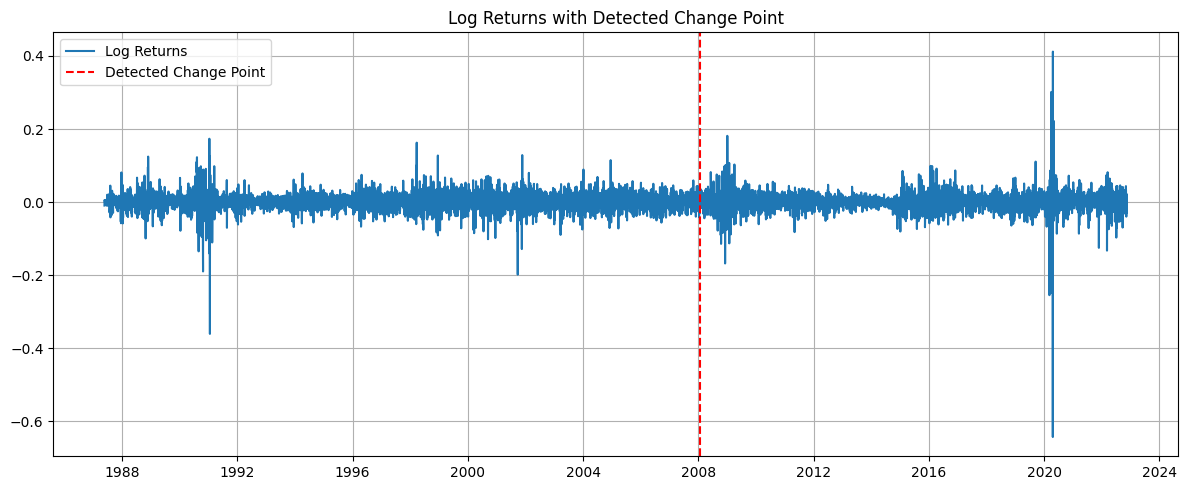

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df['log_return'], label='Log Returns')
plt.axvline(change_date, color='red', linestyle='--', label='Detected Change Point')
plt.title('Log Returns with Detected Change Point')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/img/change_point_detected.png')
plt.show()
